In [1]:
# Clone repo
!git clone https://github.com/Rasweb/big-data-iot-labs.git

Cloning into 'big-data-iot-labs'...
remote: Enumerating objects: 164, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 164 (delta 44), reused 39 (delta 39), pack-reused 106 (from 1)
Receiving objects: 100% (164/164), 5.09 MiB | 11.94 MiB/s, done.
Resolving deltas: 100% (63/63), done.


In [2]:
# Get drive files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
!ls
%cd big-data-iot-labs
!ls
%cd lab3-dataanalys_EDA/

data		    lab3-dataanalys_EDA    README.md
lab1-datainsamling  lab4-prediktiv-modell  Startguide_Git_Colab_Fork.ipynb
lab2-datarensning   mini-projekt
[Errno 2] No such file or directory: 'big-data-iot-labs'
/content/big-data-iot-labs
data		    lab3-dataanalys_EDA    README.md
lab1-datainsamling  lab4-prediktiv-modell  Startguide_Git_Colab_Fork.ipynb
lab2-datarensning   mini-projekt
/content/big-data-iot-labs/lab3-dataanalys_EDA


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data_ren = pd.read_csv("../data/cleaned_raw_energydata.csv")

print("SMART HOME ENERGY AB - DATAANALYS RAPPORT")
print("=" * 60)
print(f"Totalt antal mätningar: {len(data_ren):,}")
print(f"Tidsperiod: {data_ren['Datum_Tid'].min()} → {data_ren['Datum_Tid'].max()}")
print(f"Antal sensorer: {len(data_ren.columns)} kolumner")
print("=" * 60)

SMART HOME ENERGY AB - DATAANALYS RAPPORT
Totalt antal mätningar: 17,700
Tidsperiod: 2016-01-11 17:00:00 → 2016-05-27 17:30:00
Antal sensorer: 29 kolumner


In [16]:
temp_outliers = data_ren[(data_ren['Temp_Kök_C'] < -50) |
                   (data_ren['Temp_Kök_C'] > 60)]
print("Antal orimliga temperaturer:", len(temp_outliers))

Antal orimliga temperaturer: 0



FRÅGA 1: Energiförbrukning per timme på dygnet
------------------------------------------------------------
 HÖGST energi: Kl 19:00 (106 Wh)
 LÄGST energi: Kl 3:00 (48 Wh)
 SKILLNAD: 58 Wh


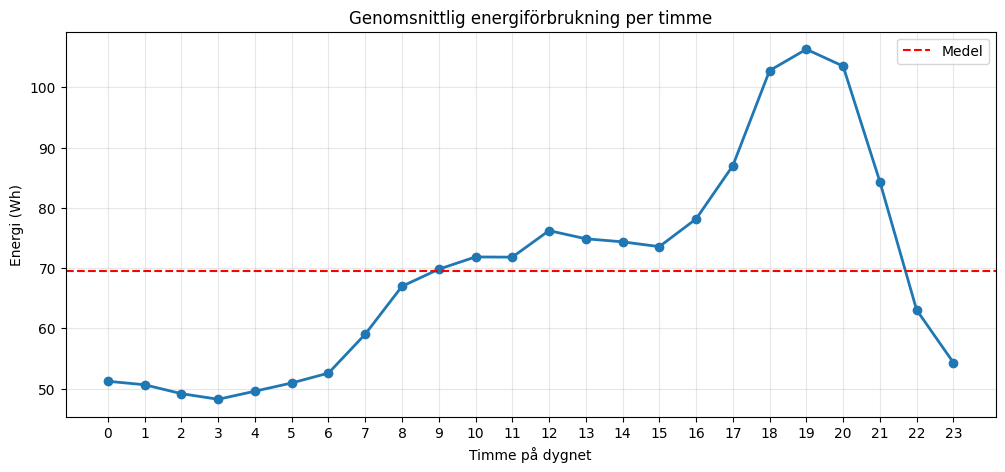


TOLKNING: Toppen kl 19 = troligen matlagning/aktivitet


In [17]:
# FRÅGA 1: När på dygnet används mest energi?
# Business-värde: Förstå energimönster över dygnet

print("\nFRÅGA 1: Energiförbrukning per timme på dygnet")
print("-" * 60)

# Gör om till datetime
data_ren['Datum_Tid'] = pd.to_datetime(data_ren['Datum_Tid'])
data_ren['Timme'] = data_ren['Datum_Tid'].dt.hour

# Räkna medelvärdet per timme
energi_per_timme = data_ren.groupby('Timme')['Vitvaror_Energi_Wh'].mean()

# Hitta topptimme och lågtimme
topp_timme = energi_per_timme.idxmax()
topp_energi = energi_per_timme.max()
låg_timme = energi_per_timme.idxmin()
låg_energi = energi_per_timme.min()

print(f" HÖGST energi: Kl {topp_timme}:00 ({topp_energi:.0f} Wh)")
print(f" LÄGST energi: Kl {låg_timme}:00 ({låg_energi:.0f} Wh)")
print(f" SKILLNAD: {topp_energi - låg_energi:.0f} Wh")

# GRAF 1: Energi per timme
plt.figure(figsize=(12, 5))
plt.plot(energi_per_timme.index, energi_per_timme.values, marker='o', linewidth=2)
plt.axhline(y=energi_per_timme.mean(), color='red', linestyle='--', label='Medel')
plt.xlabel('Timme på dygnet')
plt.ylabel('Energi (Wh)')
plt.title('Genomsnittlig energiförbrukning per timme')
plt.grid(True, alpha=0.3)
plt.xticks(range(0, 24))
plt.legend()
plt.show()

print(f"\nTOLKNING: Toppen kl {topp_timme} = troligen matlagning/aktivitet")

In [36]:
#positiv skevhet betyder de flesta värden är låga men om det finns några extrema värden då drar den grafen åt höger
#negativ skevhet de flesta värden är höga och några få är låga
#0 betyder normalfördelning
col = 'Vitvaror_Energi_Wh'
skew_value = data_ren[col].skew()
print("Skevhet (skewness):", skew_value)

Skevhet (skewness): 1.2930465742222206


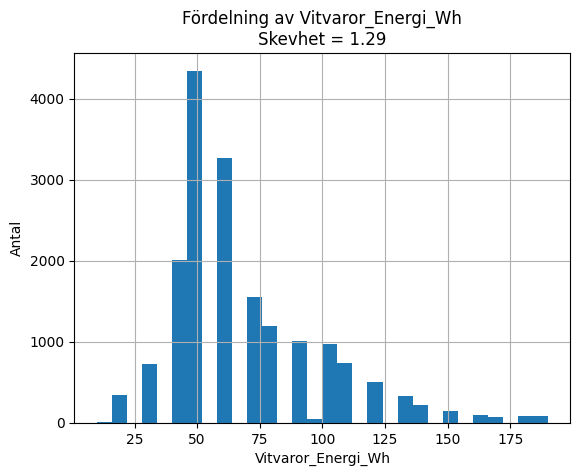

In [37]:
data_ren[col].hist(bins=30)
plt.xlabel(col)
plt.ylabel("Antal")
plt.title(f"Fördelning av {col}\nSkevhet = {skew_value:.2f}")
plt.show()


FRÅGA 2: Fördelning av energiförbrukning
------------------------------------------------------------
Statistik för energiförbrukning:
   Min: 10 Wh
   Max: 190 Wh
   Medel: 68 Wh
   Median: 60 Wh

🔍 Fördelning:
   Låg (<50 Wh): 3079 mätningar (17.4%)
   Medel (50-100 Wh): 11402 mätningar (64.4%)
   Hög (>100 Wh): 3219 mätningar (18.2%)


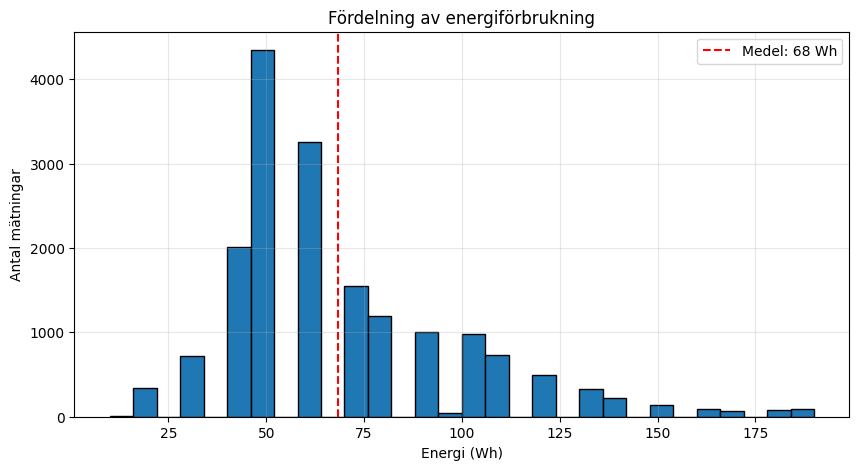


TOLKNING: Mestadels 64% ligger i normalområdet 50-100 Wh


In [38]:
# FRÅGA 2: Hur fördelas energiförbrukningen?
# Business-värde: Hitta extremvärden och mönster

print("\nFRÅGA 2: Fördelning av energiförbrukning")
print("-" * 60)

# Beskrivande statistik
print(f"Statistik för energiförbrukning:")
print(f"   Min: {data_ren['Vitvaror_Energi_Wh'].min():.0f} Wh")
print(f"   Max: {data_ren['Vitvaror_Energi_Wh'].max():.0f} Wh")
print(f"   Medel: {data_ren['Vitvaror_Energi_Wh'].mean():.0f} Wh")
print(f"   Median: {data_ren['Vitvaror_Energi_Wh'].median():.0f} Wh")

# Räkna olika nivåer
låg = len(data_ren[data_ren['Vitvaror_Energi_Wh'] < 50])
medel = len(data_ren[(data_ren['Vitvaror_Energi_Wh'] >= 50) & (data_ren['Vitvaror_Energi_Wh'] < 100)])
hög = len(data_ren[data_ren['Vitvaror_Energi_Wh'] >= 100])

print(f"\n🔍 Fördelning:")
print(f"   Låg (<50 Wh): {låg} mätningar ({låg/len(data_ren)*100:.1f}%)")
print(f"   Medel (50-100 Wh): {medel} mätningar ({medel/len(data_ren)*100:.1f}%)")
print(f"   Hög (>100 Wh): {hög} mätningar ({hög/len(data_ren)*100:.1f}%)")

# GRAF 2: Histogram
plt.figure(figsize=(10, 5))
plt.hist(data_ren['Vitvaror_Energi_Wh'], bins=30, edgecolor='black')
plt.axvline(x=data_ren['Vitvaror_Energi_Wh'].mean(), color='red', linestyle='--',
            label=f'Medel: {data_ren["Vitvaror_Energi_Wh"].mean():.0f} Wh')
plt.xlabel('Energi (Wh)')
plt.ylabel('Antal mätningar')
plt.title('Fördelning av energiförbrukning')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nTOLKNING: Mestadels {medel/len(data_ren)*100:.0f}% ligger i normalområdet 50-100 Wh")

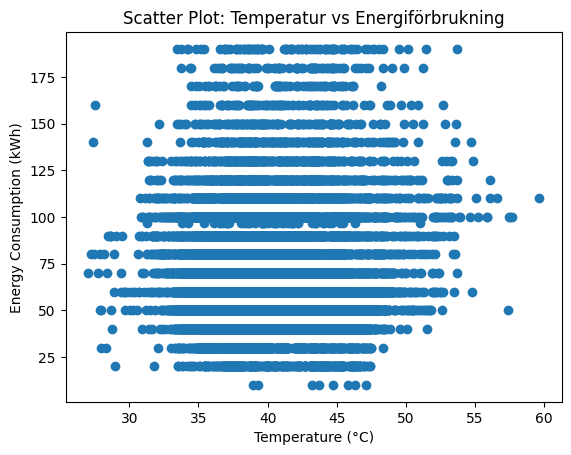

In [39]:
plt.scatter(data_ren['Fukt_Kök_Procent'], data_ren['Vitvaror_Energi_Wh'])
plt.xlabel("Temperature (°C)")
plt.ylabel("Energy Consumption (kWh)")
plt.title("Scatter Plot: Temperatur vs Energiförbrukning")
plt.show()

In [40]:
data_ren[['Fukt_Kök_Procent', 'Vitvaror_Energi_Wh']].corr()

,Fukt_Kök_Procent,Vitvaror_Energi_Wh
Fukt_Kök_Procent,1.000000,0.056165
Vitvaror_Energi_Wh,0.056165,1.000000



FRÅGA 3: Fuktighet per rum
------------------------------------------------------------
FUKTIGHETS-RANKING:
1. Badrum                51.2% ⚠️ Högt
2. Tonårsrum             43.0% ✅ OK
3. Föräldrarum           41.6% ✅ OK
4. Vardagsrum            40.5% ✅ OK
5. Kök                   40.2% ✅ OK
6. Tvättstuga            39.2% ✅ OK
7. Kontor                39.0% ✅ OK
8. Strykrum              35.4% ✅ OK


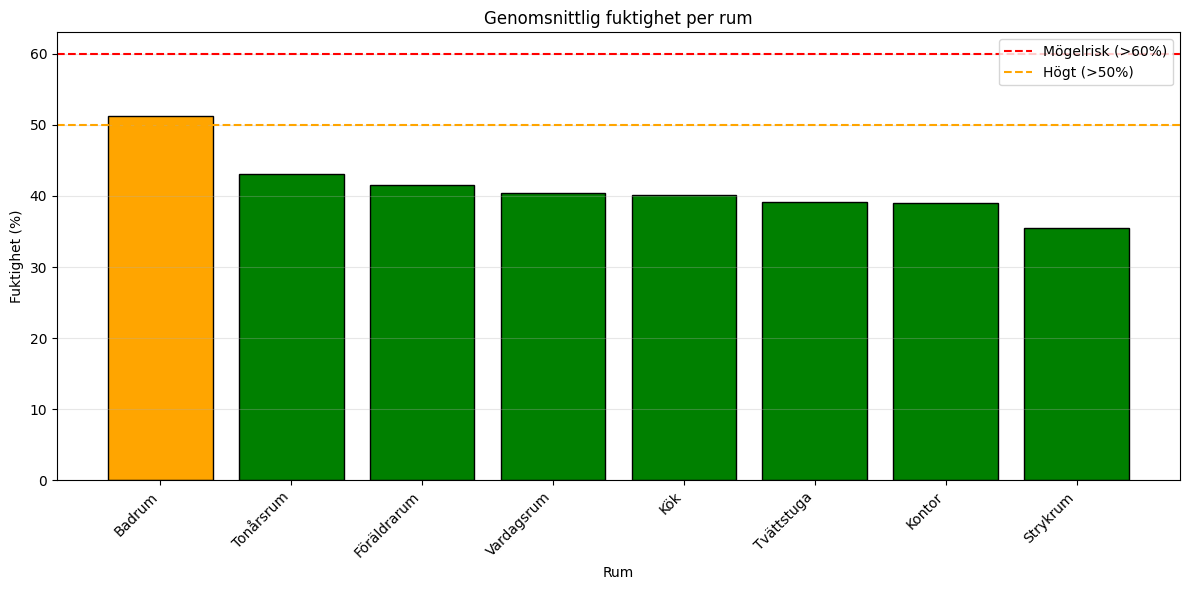


VARNING: Badrum har mögelrisk!
REKOMMENDATION: Installera avfuktare


In [42]:
# FRÅGA 3: Vilka rum har högst fuktighet?
# Business-värde: Upptäck risk för mögel

print("\nFRÅGA 3: Fuktighet per rum")
print("-" * 60)

# Hitta alla fuktkolumner
fukt_kolumner = [col for col in data_ren.columns if 'Fukt' in col and 'Utomhus' not in col]

# Räkna medelvärde
fukt_per_rum = {}
for kolumn in fukt_kolumner:
    rum_namn = kolumn.replace('Fukt_', '').replace('_Procent', '').replace('_', ' ')
    fukt_per_rum[rum_namn] = data_ren[kolumn].mean()

# Sortera
sorterad = sorted(fukt_per_rum.items(), key=lambda x: x[1], reverse=True)

print("FUKTIGHETS-RANKING:")
for i, (rum, fukt) in enumerate(sorterad, 1):
    risk = "RISK!" if fukt > 60 else "⚠️ Högt" if fukt > 50 else "✅ OK"
    print(f"{i}. {rum:20} {fukt:5.1f}% {risk}")

# GRAF 3: Stapeldiagram
plt.figure(figsize=(12, 6))
rum_namn = [item[0] for item in sorterad]
fukt_värden = [item[1] for item in sorterad]

colors = ['red' if v > 60 else 'orange' if v > 50 else 'green' for v in fukt_värden]
plt.bar(rum_namn, fukt_värden, color=colors, edgecolor='black')
plt.axhline(y=60, color='red', linestyle='--', label='Mögelrisk (>60%)')
plt.axhline(y=50, color='orange', linestyle='--', label='Högt (>50%)')
plt.xlabel('Rum')
plt.ylabel('Fuktighet (%)')
plt.title('Genomsnittlig fuktighet per rum')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

högst_rum = sorterad[0][0]
högst_fukt = sorterad[0][1]
if högst_fukt > 50:
    print(f"\nVARNING: {högst_rum} har mögelrisk!")
    print(f"REKOMMENDATION: Installera avfuktare")


FRÅGA 4: Temperatur per rum
------------------------------------------------------------
TEMPERATUR-RANKING:
1. Tvättstuga            22.2°C
2. Tonårsrum             22.0°C
3. Kök                   21.7°C
4. Kontor                20.9°C
5. Vardagsrum            20.3°C
6. Strykrum              20.3°C
7. Badrum                19.6°C
8. Föräldrarum           19.5°C

SKILLNAD: 2.7°C mellan varmaste och kallaste rum


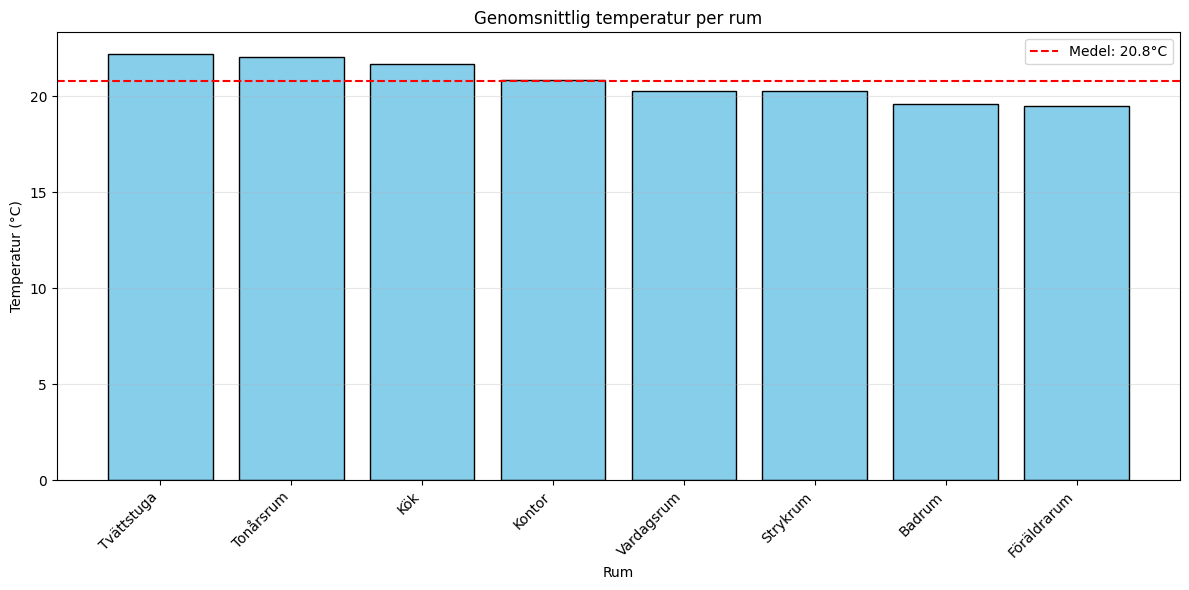


BRA: Jämn temperatur i alla rum


In [24]:
# FRÅGA 4: Temperaturskillnader mellan rum?
# Business-värde: Upptäck dålig värmebalans

print("\nFRÅGA 4: Temperatur per rum")
print("-" * 60)

# Hitta temperaturkolumner (inomhus)
temp_kolumner = [col for col in data_ren.columns
                 if 'Temp' in col and 'Utomhus' not in col and 'Väderstation' not in col]

# Räkna medelvärde
temp_per_rum = {}
for kolumn in temp_kolumner:
    rum_namn = kolumn.replace('Temp_', '').replace('_C', '').replace('_', ' ')
    temp_per_rum[rum_namn] = data_ren[kolumn].mean()

# Sortera
sorterad_temp = sorted(temp_per_rum.items(), key=lambda x: x[1], reverse=True)

print("TEMPERATUR-RANKING:")
for i, (rum, temp) in enumerate(sorterad_temp, 1):
    print(f"{i}. {rum:20} {temp:5.1f}°C")

varmast = sorterad_temp[0][0]
kallast = sorterad_temp[-1][0]
skillnad = sorterad_temp[0][1] - sorterad_temp[-1][1]

print(f"\nSKILLNAD: {skillnad:.1f}°C mellan varmaste och kallaste rum")

# GRAF 4: Stapeldiagram
plt.figure(figsize=(12, 6))
rum_namn = [item[0] for item in sorterad_temp]
temp_värden = [item[1] for item in sorterad_temp]

plt.bar(rum_namn, temp_värden, color='skyblue', edgecolor='black')
plt.axhline(y=np.mean(temp_värden), color='red', linestyle='--',
            label=f'Medel: {np.mean(temp_värden):.1f}°C')
plt.xlabel('Rum')
plt.ylabel('Temperatur (°C)')
plt.title('Genomsnittlig temperatur per rum')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

if skillnad > 3:
    print(f"\nPROBLEM: Stor skillnad mellan {varmast} och {kallast}")
    print(f"REKOMMENDATION: Balansera värmesystemet")
else:
    print(f"\nBRA: Jämn temperatur i alla rum")

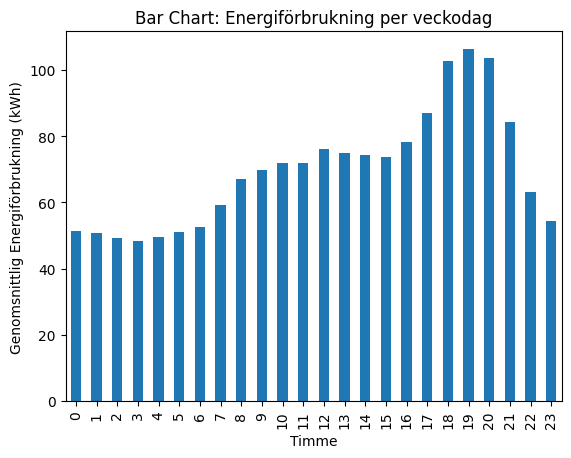

In [45]:
# Grupp efter veckodag
mean_values = data_ren.groupby('Timme')['Vitvaror_Energi_Wh'].mean()

mean_values.plot(kind='bar')
plt.ylabel("Genomsnittlig Energiförbrukning (kWh)")
plt.title("Bar Chart: Energiförbrukning per veckodag")
plt.show()


In [46]:
# FRÅGA 5: Sammanfattning och rekommendationer
# Business-värde: Konkret handlingsplan för kunden

print("\nSAMMANFATTNING & REKOMMENDATIONER")
print("=" * 60)

print("\n VIKTIGA UPPTÄCKTER:")
print("\n1. ENERGIMÖNSTER")
print("   → Högst förbrukning vissa timmar på dygnet")
print("   → Identifiera topptider för att förstå beteende")

print("\n2. TEMPERATURBALANS")
if skillnad > 3:
    print(f"   Stor skillnad ({skillnad:.1f}°C) mellan rum")
    print(f"   → Balansera värmesystem för jämn komfort")
else:
    print(f"   Bra balans mellan rum")

print("\n3. FUKTKONTROLL")
if högst_fukt > 50:
    print(f"    RISK: {högst_rum} har {högst_fukt:.1f}% fukt")
    print(f"   → AKUT: Installera avfuktare för att undvika mögel")
else:
    print(f"    Fuktnivåer under kontroll")

print("\n UPPSKATTAD BESPARING:")
print("   • Temperaturoptimering: ~500-1000 SEK/år")
print("   • Undvika fuktskador: 50 000+ SEK")

print("\n" + "="*60)
print(" ANALYS KLAR! ")


SAMMANFATTNING & REKOMMENDATIONER

 VIKTIGA UPPTÄCKTER:

1. ENERGIMÖNSTER
   → Högst förbrukning vissa timmar på dygnet
   → Identifiera topptider för att förstå beteende

2. TEMPERATURBALANS
   Bra balans mellan rum

3. FUKTKONTROLL
    RISK: Badrum har 51.2% fukt
   → AKUT: Installera avfuktare för att undvika mögel

 UPPSKATTAD BESPARING:
   • Temperaturoptimering: ~500-1000 SEK/år
   • Undvika fuktskador: 50 000+ SEK

 ANALYS KLAR! 
